In [2]:
import jax
import jax.numpy as jnp
import genjax
genjax.pretty()
import b3d
import b3d.chisight.gen3d as gen3d
from tqdm import tqdm

In [3]:
problematic_scene_specs = [(2, 5), (3, 0), (3, 1), (3, 2), (4, 1), (4, 3), (5, 0)]
spec = problematic_scene_specs[2]
scene_id, object_idx = spec

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:03<00:00, 12.39it/s]
/home/georgematheos/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


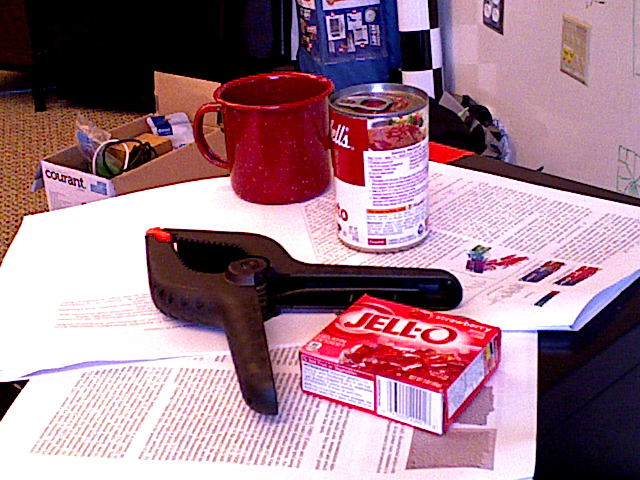

In [4]:
all_data, meshes, renderer, intrinsics, initial_object_poses = gen3d.dataloading.load_scene(
    scene_id, FRAME_RATE=50, subdir="train_real"
)
b3d.viz_rgb(all_data[0]["rgbd"])

In [5]:
template_pose, model_vertices, model_colors = gen3d.dataloading.load_object_given_scene(
    all_data, meshes, renderer, object_idx
)

In [6]:
hyperparams = gen3d.settings.hyperparams
hyperparams["intrinsics"] = intrinsics
hyperparams["vertices"] = model_vertices
hyperparams

{'pose_kernel': GaussianVMFPoseDriftKernel(...),
 'color_kernel': RenormalizedLaplaceColorDriftKernel(...),
 'visibility_prob_kernel': DiscreteFlipKernel(...),
 'depth_nonreturn_prob_kernel': DiscreteFlipKernel(...),
 'depth_scale_kernel': DiscreteFlipKernel(...),
 'color_scale_kernel': DiscreteFlipKernel(...),
 'image_kernel': UniquePixelsImageKernel(...),
 'unexplained_depth_nonreturn_prob': 0.02,
 'intrinsics': {'fx': <jax.Array(1066.778, dtype=float32)>,
  'fy': <jax.Array(1067.487, dtype=float32)>,
  'cx': <jax.Array(312.9869, dtype=float32)>,
  'cy': <jax.Array(241.3109, dtype=float32)>,
  'image_height': Const(...),
  'image_width': Const(...),
  'near': 0.01,
  'far': 3.0},
 'vertices': <jax.Array float32(10000, 3) ≈0.01 ±0.02 [≥-0.047, ≤0.051] nonzero:30_000
   <Arrayviz rendering>
 >}

In [7]:
inference_hyperparams = gen3d.settings.inference_hyperparams
inference_hyperparams = gen3d.hyperparams.InferenceHyperparams(**{
    **inference_hyperparams.attributes_dict(),
    # "pose_proposal_args": [(0.04, 1000.0)]
})
inference_hyperparams

InferenceHyperparams(...)

In [8]:
def get_gt_pose(T):
    return (
        all_data[T]["camera_pose"].inv()
        @ all_data[T]["object_poses"][object_idx]
    )

In [9]:
initial_state = gen3d.dataloading.get_initial_state(
    template_pose, model_vertices, model_colors, hyperparams
)

In [10]:
key = jax.random.PRNGKey(156)
og_trace = gen3d.inference.get_initial_trace(
    key, hyperparams, initial_state, all_data[0]["rgbd"]
)

/home/georgematheos/b3d/src/b3d/modeling_utils.py:87: UserWarning: RenormalizedLaplace sampling is currently not implemented perfectly.
  warnings.warn(


In [11]:
b3d.rr_init("inference_debugging-3-1-2")


In [12]:
b3d.reload(gen3d.inference)
b3d.reload(b3d.chisight.gen3d.point_attribute_proposals)

In [13]:
tracking_results = {}
maxT = 20
key = jax.random.PRNGKey(1)
trace = og_trace
for T in tqdm(range(maxT)):
    key = b3d.split_key(key)
    prev_trace = trace
    trace, _, all_weights, all_poses, keys_to_regen = gen3d.inference.inference_step(
        key,
        trace,
        all_data[T]["rgbd"],
        inference_hyperparams,
        gt_pose=get_gt_pose(T),
        use_gt_pose=True,
        get_all_weights = True
    )
    tracking_results[T] = trace

    gt_pose, gt_key = all_poses[0], keys_to_regen[0]
    gt_trace = gen3d.inference.get_trace_generated_during_inference(
        gt_key, prev_trace, gt_pose, inference_hyperparams,
        observed_rgbd=all_data[T]["rgbd"]
    )

    gen3d.model.viz_trace(
        trace,
        T,
        ground_truth_vertices=meshes[object_idx].vertices,
        ground_truth_pose=get_gt_pose(T),
    )

    if jnp.linalg.norm(gt_pose.position - gen3d.model.get_new_state(trace)["pose"].position) > 0.02:
        b3d.rr_init("gt_pose_trace-3-1")
        gen3d.model.viz_trace(gt_trace, T, ground_truth_vertices=meshes[object_idx].vertices, ground_truth_pose=get_gt_pose(T))
        break

  0%|          | 0/20 [00:00<?, ?it/s]/home/georgematheos/b3d/src/b3d/modeling_utils.py:87: UserWarning: RenormalizedLaplace sampling is currently not implemented perfectly.
  warnings.warn(
 95%|█████████▌| 19/20 [08:11<00:25, 25.86s/it]


In [14]:
trace.get_score()

<jax.Array(-248620.8, dtype=float32)>

In [15]:
gt_trace.get_score()

<jax.Array(-inf, dtype=float32)>

In [16]:
gt_trace.subtraces[6]

DistributionTrace(...)

In [17]:
observed_rgbd = all_data[6]["rgbd"]
state = gen3d.model.get_new_state(gt_trace)
intrinsics = hyperparams["intrinsics"]
(
    observed_rgbd_per_point,
    latent_rgbd_per_point,
    is_valid,
    _,
    point_indices_for_observed_rgbds,
) = gen3d.image_kernel.calculate_latent_and_observed_correspondences(
    observed_rgbd, state, hyperparams
)

In [18]:
state["depth_nonreturn_prob"][point_indices_for_observed_rgbds[0]]

<jax.Array(1., dtype=float32)>

In [19]:
scores = jax.vmap(
    hyperparams["image_kernel"].get_rgbd_vertex_kernel().logpdf,
    in_axes=(0, 0, None, None, 0, 0, None, None),
)(
    observed_rgbd_per_point,
    latent_rgbd_per_point,
    state["color_scale"],
    state["depth_scale"],
    state["visibility_prob"][point_indices_for_observed_rgbds],
    state["depth_nonreturn_prob"][point_indices_for_observed_rgbds],
    hyperparams["intrinsics"],
    hyperparams["unexplained_depth_nonreturn_prob"]
)
jnp.isinf(scores)

# jax.Array bool(10000,) true:7_894 false:2_106
  Array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [20]:
observed_rgbd_per_point[-1]

<Array([-1., -1., -1., -1.], dtype=float32, weak_type=True)
  <Arrayviz rendering>
>

In [21]:
is_valid[42]

<jax.Array(True, dtype=bool)>

In [22]:
latent_rgbd_per_point[42]

<Array([0.99999994, 0.05882353, 0.05882353, 0.7174354 ], dtype=float32)
  <Arrayviz rendering>
>

In [23]:
observed_rgbd_per_point[42]

<Array([0.11764705, 0.05882353, 0.04313725, 0.        ],      dtype=float32, weak_type=True)
  <Arrayviz rendering>
>

In [24]:
state["visibility_prob"][point_indices_for_observed_rgbds][42]

<jax.Array(1., dtype=float32)>

In [25]:
state["depth_nonreturn_prob"][point_indices_for_observed_rgbds][42]

<jax.Array(0., dtype=float32)>

In [26]:
observed_rgbd = observed_rgbd_per_point[0]
latent_rgbd = latent_rgbd_per_point[0]
color_scale = state["color_scale"]
depth_scale = state["depth_scale"]
visibility_prob = state["visibility_prob"][point_indices_for_observed_rgbds][0]
depth_nonreturn_prob = state["depth_nonreturn_prob"][point_indices_for_observed_rgbds][0]
intrinsics = hyperparams["intrinsics"]

hyperparams["image_kernel"].get_rgbd_vertex_kernel().logpdf(
    observed_rgbd,
    latent_rgbd,
    color_scale,
    depth_scale,
    visibility_prob,
    0.,
    intrinsics,
    hyperparams["unexplained_depth_nonreturn_prob"]
)

<jax.Array(-inf, dtype=float32)>

In [27]:
def get_trace_generated_during_inference(
    key, trace, pose, inference_hyperparams,
    do_advance_time=True,
    observed_rgbd=None,
    just_return_trace=True
):
    """
    Get the trace generated at pose `pose` with key `key` by inference_step,
    when it was given `trace`, `do_advance_time`, `inference_hyperparams`,
    and `observed_rgbd` as input.
    """
    if do_advance_time:
        assert observed_rgbd is not None
        trace = gen3d.inference.advance_time(key, trace, observed_rgbd)
    vals = gen3d.inference.propose_other_latents_given_pose(key, trace, pose, inference_hyperparams)
    if just_return_trace:
        return vals[0]
    else:
        return vals


In [28]:
_, _, metadata = get_trace_generated_during_inference(
    gt_key, prev_trace, gt_pose, inference_hyperparams,
    observed_rgbd=all_data[T]["rgbd"],
    just_return_trace=False
)
jax.tree.map(lambda x: x[0], metadata["point_attribute_proposal_metadata"])

{'all_visprob_dnrprob_pairs': <jax.Array float32(4, 2) ≈0.5 ±0.5 [≥0.0, ≤1.0] zero:4 nonzero:4
   <Arrayviz rendering>
 >,
 'index': <jax.Array(2, dtype=int32)>,
 'log_normalized_scores': <Array([-1.3862944, -1.3862944, -1.3862944, -1.3862944], dtype=float32)
   <Arrayviz rendering>
 >,
 'log_q_score': <jax.Array(16.56438, dtype=float32)>,
 'log_qs_rgb': <Array([17.950676, 17.950676, 17.950676, 17.950676], dtype=float32)
   <Arrayviz rendering>
 >,
 'rgb_proposal_metadata': {'isvalid': <jax.Array([False, False, False, False], dtype=bool)>,
  'log_q_if_invalid': <Array([17.950676, 17.950676, 17.950676, 17.950676], dtype=float32)
    <Arrayviz rendering>
  >,
  'metadata_if_valid': {'log_K_score': <Array([-inf, -inf, -inf, -inf], dtype=float32)
     <Arrayviz rendering>
   >,
   'log_L_score': <Array([-inf,  nan, -inf, -inf], dtype=float32)
     <Arrayviz rendering>
   >,
   'log_qs': <jax.Array float32(4, 2) ≈6.3 ±0.0 [≥-inf, ≤6.3] nonzero:8 -inf:4
     <Arrayviz rendering>
   >,
   'normalized_scores': <jax.Array float32(4, 2) ≈-0.69 ±0.0 [≥-0.69, ≤-0.69] nonzero:8
     <Arrayviz rendering>
   >,
   'overall_score': <Array([nan, nan, nan, nan], dtype=float32)
     <Arrayviz rendering>
   >,
   'proposed_rgbs': <jax.Array float32(4, 2, 3) ≈-0.36 ±0.7 [≥-1.0, ≤0.83] zero:8 nonzero:16
     <Arrayviz rendering>
   >,
   'sampled_index': <Array([0, 1, 0, 0], dtype=int32)
     <Arrayviz rendering>
   >,
   'sampled_rgb': <jax.Array float32(4, 3) ≈-0.042 ±0.65 [≥-1.0, ≤0.83] zero:6 nonzero:6
     <Arrayviz rendering>
   >},
  'value_if_observed_is_invalid': <jax.Array float32(4, 3) ≈0.28 ±0.39 [≥0.0, ≤0.83] zero:8 nonzero:4
    <Arrayviz rendering>
  >}}

In [29]:
metadata["point_attribute_proposal_metadata"]

{'all_visprob_dnrprob_pairs': <jax.Array float32(10000, 4, 2) ≈0.5 ±0.5 [≥0.0, ≤1.0] zero:40_000 nonzero:40_000
   <Arrayviz rendering>
 >,
 'index': <jax.Array int32(10000,) [≥0, ≤3] zero:2_179 nonzero:7_821
   <Arrayviz rendering>
 >,
 'log_normalized_scores': <jax.Array float32(10000, 4) ≈-2.4 ±3.0 [≥-inf, ≤-5.7e-06] nonzero:40_000 -inf:3_973
   <Arrayviz rendering>
 >,
 'log_q_score': <jax.Array float32(10000,) ≈1.2e+01 ±5.1 [≥0.38, ≤1.7e+01] nonzero:10_000
   <Arrayviz rendering>
 >,
 'log_qs_rgb': <jax.Array float32(10000, 4) ≈1.3e+01 ±5.7 [≥4.2, ≤1.9e+01] nonzero:40_000
   <Arrayviz rendering>
 >,
 'rgb_proposal_metadata': {'isvalid': # jax.Array bool(10000, 4) true:15_892 false:24_108
    Array([[False, False, False, False],
           [ True,  True,  True,  True],
           [False, False, False, False],
           ...,
           [False, False, False, False],
           [False, False, False, False],
           [ True,  True,  True,  True]], dtype=bool)
  ,
  'log_q_if_invalid': <jax.Array float32(10000, 4) ≈1.7e+01 ±0.59 [≥1.7e+01, ≤1.9e+01] nonzero:40_000
    <Arrayviz rendering>
  >,
  'metadata_if_valid': {'log_K_score': <jax.Array float32(10000, 4) ≈1.1e+01 ±0.77 [≥-inf, ≤1.4e+01] nonzero:40_000 -inf:24_108
     <Arrayviz rendering>
   >,
   'log_L_score': <jax.Array float32(10000, 4) ≈5.4 ±0.48 [≥-inf, ≤6.9] nonzero:40_000 nan:11_997 -inf:12_111
     <Arrayviz rendering>
   >,
   'log_qs': <jax.Array float32(10000, 4, 2) ≈5.6 ±0.55 [≥-inf, ≤6.9] nonzero:80_000 -inf:24_108
     <Arrayviz rendering>
   >,
   'normalized_scores': <jax.Array float32(10000, 4, 2) ≈-7e+01 ±2.1e+02 [≥-1.5e+03, ≤0.0] zero:11_907 nonzero:68_093
     <Arrayviz rendering>
   >,
   'overall_score': <jax.Array float32(10000, 4) ≈5.6 ±0.62 [≥4.2, ≤6.9] nonzero:40_000 nan:24_108
     <Arrayviz rendering>
   >,
   'proposed_rgbs': <jax.Array float32(10000, 4, 2, 3) ≈0.09 ±0.78 [≥-1.0, ≤1.0] zero:19_852 nonzero:220_148
     <Arrayviz rendering>
   >,
   'sampled_index': <jax.Array int32(10000, 4) [≥0, ≤1] zero:26_012 nonzero:13_988
     <Arrayviz rendering>
   >,
   'sampled_rgb': <jax.Array float32(10000, 4, 3) ≈0.11 ±0.79 [≥-1.0, ≤1.0] zero:10_794 nonzero:109_206
     <Arrayviz rendering>
   >},
  'value_if_observed_is_invalid': <jax.Array float32(10000, 4, 3) ≈0.61 ±0.36 [≥0.0, ≤1.0] zero:14_788 nonzero:105_212
    <Arrayviz rendering>
  >}}

In [30]:
hyperparams["image_kernel"].get_rgbd_vertex_kernel().outlier_color_distribution.logpdf(
    observed_rgbd[:3], latent_rgbd[:3], color_scale
)

<jax.Array(0., dtype=float32)>

In [31]:
s = hyperparams["image_kernel"].get_rgbd_vertex_kernel()

In [32]:
.outlier_depth_distribution.logpdf(
    observed_rgbd[3], latent_rgbd[3], depth_scale, intrinsics["near"], intrinsics["far"]
)

SyntaxError: invalid syntax (3129153674.py, line 1)

In [86]:
total_log_prob = 0.0
is_depth_non_return = observed_rgbd[3] == 0.0

# Is visible
total_visible_log_prob = 0.0
# color term
total_visible_log_prob += s.inlier_color_distribution.logpdf(
    observed_rgbd[:3], latent_rgbd[:3], color_scale
)
# depth term
total_visible_log_prob += jnp.where(
    is_depth_non_return,
    jnp.log(depth_nonreturn_prob),
    jnp.log(1 - depth_nonreturn_prob)
    + s.inlier_depth_distribution.logpdf(
        observed_rgbd[3],
        latent_rgbd[3],
        depth_scale,
        intrinsics["near"],
        intrinsics["far"],
    ),
)


In [89]:
jnp.log(1 - depth_nonreturn_prob)

<jax.Array(-inf, dtype=float32)>

In [91]:
total_not_visible_log_prob = 0.0
# color term
outlier_color_log_prob = s.outlier_color_distribution.logpdf(
    observed_rgbd[:3],
    latent_rgbd[:3],
    color_scale,
)
outlier_depth_log_prob = s.outlier_depth_distribution.logpdf(
    observed_rgbd[3],
    latent_rgbd[3],
    depth_scale,
    intrinsics["near"],
    intrinsics["far"],
)
outlier_depth_log_prob + outlier_color_log_prob

<jax.Array(-1.0952734, dtype=float32)>

In [93]:
total_not_visible_log_prob += outlier_color_log_prob
# depth term
total_not_visible_log_prob += jnp.where(
    is_depth_non_return,
    jnp.log(depth_nonreturn_prob),
    jnp.log(1 - depth_nonreturn_prob) + outlier_depth_log_prob,
)
total_not_visible_log_prob

<jax.Array(-inf, dtype=float32)>